# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import os
#from wmi import WMI
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
import psutil


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)

path = 'D:/Harvard/HW7/' # '/Volumes/EMTEC/Harvard/HW7/'
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

# separate out x and y for train and test
x_train, y_train = data_train[['Biomarker 1', 'Biomarker 2']], data_train['Diagnosis']
x_test, y_test = data_test[['Biomarker 1', 'Biomarker 2']], data_test['Diagnosis']

# save datasets to dict for later permutations
datasets = {}
datasets['original'] = {'x_train':x_train, 'y_train':y_train, \
                        'x_test':x_test, 'y_test':y_test}
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

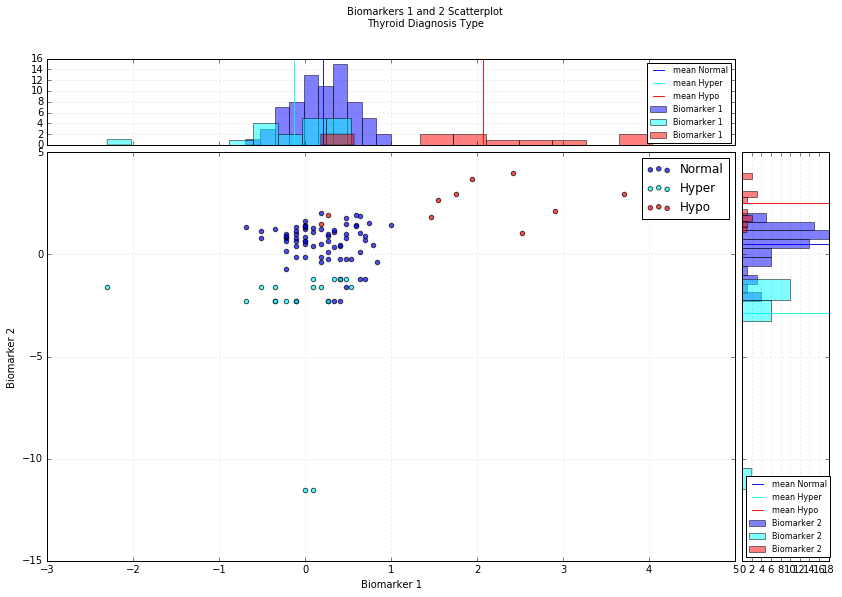

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(14, 9))
ax.set_xlabel('Biomarker 1')
ax.set_ylabel('Biomarker 2')
ax.grid(alpha=.3)

# top and right axes
divider = make_axes_locatable(ax)
axHistx = divider.append_axes('top', 1.2, pad=0.1, sharex=ax)
axHisty = divider.append_axes('right', 1.2, pad=0.1, sharey=ax)
axHistx.grid(alpha=.3)
axHisty.grid(alpha=.3)

# biomarker histograms by type
for diagnosis, col in zip([1, 2, 3], ['blue', 'cyan', 'red']):
    if diagnosis == 1:
        label = 'Normal'
    elif diagnosis == 2:
        label = 'Hyper'
    else:
        label = 'Hypo'
    axHistx.hist(data_train.loc[data_train.Diagnosis == diagnosis, 'Biomarker 1'], \
                 color=col, alpha=.5)
    axHistx.axvline(data_train.loc[data_train.Diagnosis == diagnosis, 'Biomarker 1'].mean(), \
                 color=col, alpha=.9, label='mean ' + label)
    axHisty.hist(data_train.loc[data_train.Diagnosis == diagnosis, 'Biomarker 2'], \
                 color=col, orientation='horizontal', alpha=.5)
    axHisty.axhline(data_train.loc[data_train.Diagnosis == diagnosis, 'Biomarker 2'].mean(), \
                 color=col, alpha=.9, label='mean ' + label)
    ax.scatter(data_train.loc[data_train.Diagnosis == diagnosis, 'Biomarker 1'], \
               data_train.loc[data_train.Diagnosis == diagnosis, 'Biomarker 2'], \
               c=col, label=label, alpha=.7)

# make some labels invisible & show legend
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(), visible=False)
plt.suptitle('Biomarkers 1 and 2 Scatterplot\nThyroid Diagnosis Type')
ax.legend(loc='best')
axHistx.legend(loc='best', prop={'size':8})
axHisty.legend(loc='best', prop={'size':8})

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def multiclass_confusion_matrix(y, yhat, model_name='unspecified'):
    '''
    Inputs:
    ------------------------------------------------------
    y: true labels 
    yhat: predicted labels 
    model_name: name of model for printing
    
    Outputs:
    ------------------------------------------------------
    cm: confusion matrix (easily readable)
    metrics: dict of metrics on multiclass classification
    '''
    # organize confusion matrix from sklearn into readable format
    sk_confusion_matrix = confusion_matrix(y, yhat).transpose()#; print(sk_confusion_matrix)
    
    # put in pd.DataFrame and add names
    cm = pd.DataFrame(sk_confusion_matrix)
    IX = ['Test_' + str(i+1) for i in cm.index]
    COLS = ['Condition_' + str(i+1) for i in cm.columns]
    cm.columns, cm.index = COLS, IX
    
    # add totals
    cm['Total'] = cm.sum(axis=1)
    cm.loc['Total'] = cm.sum(axis=0)
    
    # get performance scores
    N = cm.loc['Total', 'Total']
    TP = np.diag(cm.loc[IX, COLS]).sum()
    ACC = np.divide(TP, N)
    MCR = 1 - ACC
    
    metrics = {'accuracy':ACC, 'misclassification':MCR}
    
    print('''
    Confusion Matrix for Model: %s
    ------------------------------------------------------''' %model_name)
    print(cm)
    print('''
    Metrics for Model: %s
    ------------------------------------------------------
    Accuracy Rate = %.5f
    Misclassification Rate = %.5f
    ''' %(model_name, ACC, MCR))

    return cm, metrics

def memory():
    '''
    Measure memory usage; modified from:
    https://stackoverflow.com/questions/938733/total-memory-used-by-python-process
    '''
    #w = WMI('.')
    #result = w.query("SELECT WorkingSet FROM Win32_PerfRawData_PerfProc_Process WHERE IDProcess=%d" % os.getpid())
    result = psutil.virtual_memory()[3]
    
    return result#int(result[0].WorkingSet)


def cv_optimize_evaluate(model, param_grid, x_train, y_train, x_test, y_test, model_name):
    '''
    Inputs:
    ------------------------------------------------------
    model: classifier model of sklearn API
    param_grid: paramete grid for optimizing model above
    x_train: training set of predictors
    y_train: training set of labels
    x_test: testing set of predictors
    y_test: testing set of labels
    model_name: label for plots
    
    Outputs:
    ------------------------------------------------------
    model_characteristics:
        - model_name: identifier
        - model: trained model
        - yhat: test predictions
        - confusion_matrix: confusion matrix
        - metrics: accuracy & misclassification
        - memory_usage: amount of memory used up
        - probabilities: phats from test set
        - y_test: true labels
    '''
    # stake memory gauge
    m1 = memory()
    
    # get one v. rest model and make predictions on test set
    if param_grid != None:
        model = GridSearchCV(model, param_grid)
    model.fit(x_train, y_train)
    yhat = model.predict(x_test)
    try:
        best_train_score = model.best_score_
        print('Training Score: %.4f' %best_train_score)
    except AttributeError:
        best_train_score = np.nan
    
    # compare to second memory gauge
    m2 = memory()
    delta_memory = m2 - m1
    
    # get confusion matrix and metrics
    cm, metrics = multiclass_confusion_matrix(y_test, yhat, model_name)
    
    # get model's probabilities
    proba = model.predict_proba(x_test)
    
    # store in dict for access
    model_characteristics = {'model_name':model_name, 'model':model, 'train_score':best_train_score, \
                             'confusion_matrix':cm, 'metrics':metrics, 'memory_usage':delta_memory, \
                             'probabilities':proba, 'y_hat':yhat, 'y_test':y_test}
    
    return model_characteristics

In [5]:
# create dict for one place to store model characteristics
model_characteristics = {}

# set paramter grid for searching
param_grid = {'C':[.001, .01, .1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]}

# get one v. rest model and characteristics
logit_ovr = LogisticRegression(penalty='l2', multi_class='ovr', solver='lbfgs')
model_characteristics['logit_ovr'] = cv_optimize_evaluate(model=logit_ovr, \
                                           param_grid=param_grid, \
                                           x_train=datasets['original']['x_train'], \
                                           y_train=datasets['original']['y_train'], \
                                           x_test=datasets['original']['x_test'], \
                                           y_test=datasets['original']['y_test'], \
                                           model_name='one_v_rest_logit')

# get multinomial model and make predictions on test set
logit_mnm = LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs')
model_characteristics['logit_multinomial'] = cv_optimize_evaluate(model=logit_mnm, \
                                           param_grid=param_grid, \
                                           x_train=datasets['original']['x_train'], \
                                           y_train=datasets['original']['y_train'], \
                                           x_test=datasets['original']['x_test'], \
                                           y_test=datasets['original']['y_test'], \
                                           model_name='multinomial_logit')

Training Score: 0.8627

    Confusion Matrix for Model: one_v_rest_logit
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           74            8            3     85
Test_2            3            9            0     12
Test_3            0            0           16     16
Total            77           17           19    113

    Metrics for Model: one_v_rest_logit
    ------------------------------------------------------
    Accuracy Rate = 0.87611
    Misclassification Rate = 0.12389
    
Training Score: 0.8627

    Confusion Matrix for Model: multinomial_logit
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           74            7            4     85
Test_2            3           10            0     13
Test_3            0            0           15     15
Total            77           17           19    113

    Metrics for Model: multinomial

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# add quadratic features to both x_test and x_train
quad = PolynomialFeatures(degree=2, include_bias=False)
datasets['quadratic'] = {'x_train':quad.fit_transform(x_train), 'y_train':y_train, \
                        'x_test':quad.fit_transform(x_test), 'y_test':y_test}

# get multinomial model and make predictions on test set
logit_qlog = LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs')
model_characteristics['logit_quadratic'] = cv_optimize_evaluate(model=logit_qlog, \
                                           param_grid=param_grid, \
                                           x_train=datasets['quadratic']['x_train'], \
                                           y_train=datasets['quadratic']['y_train'], \
                                           x_test=datasets['quadratic']['x_test'], \
                                           y_test=datasets['quadratic']['y_test'], \
                                           model_name='multinomial_quadratic_logit')

Training Score: 0.8725

    Confusion Matrix for Model: multinomial_quadratic_logit
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           73            6            3     82
Test_2            4           11            0     15
Test_3            0            0           16     16
Total            77           17           19    113

    Metrics for Model: multinomial_quadratic_logit
    ------------------------------------------------------
    Accuracy Rate = 0.88496
    Misclassification Rate = 0.11504
    


In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

param_grid = {'solver':['svd', 'lsqr', 'eigen']}

# get LDA and make predictions on test set
lda = LinearDiscriminantAnalysis()
model_characteristics['lda'] = cv_optimize_evaluate(model=lda, \
                                           param_grid=param_grid, \
                                           x_train=datasets['original']['x_train'], \
                                           y_train=datasets['original']['y_train'], \
                                           x_test=datasets['original']['x_test'], \
                                           y_test=datasets['original']['y_test'], \
                                           model_name='linear_discriminant_analysis')

Training Score: 0.8431

    Confusion Matrix for Model: linear_discriminant_analysis
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           74           12            4     90
Test_2            3            5            0      8
Test_3            0            0           15     15
Total            77           17           19    113

    Metrics for Model: linear_discriminant_analysis
    ------------------------------------------------------
    Accuracy Rate = 0.83186
    Misclassification Rate = 0.16814
    


C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [8]:
param_grid = {'reg_param':np.arange(0, 1, .01)}

# get QDA and make predictions on test set
qda = QuadraticDiscriminantAnalysis()
model_characteristics['qda'] = cv_optimize_evaluate(model=qda, \
                                           param_grid=param_grid, \
                                           x_train=datasets['original']['x_train'], \
                                           y_train=datasets['original']['y_train'], \
                                           x_test=datasets['original']['x_test'], \
                                           y_test=datasets['original']['y_test'], \
                                           model_name='quadratic_discriminant_analysis')

Training Score: 0.8627

    Confusion Matrix for Model: quadratic_discriminant_analysis
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           73            7            4     84
Test_2            4           10            0     14
Test_3            0            0           15     15
Total            77           17           19    113

    Metrics for Model: quadratic_discriminant_analysis
    ------------------------------------------------------
    Accuracy Rate = 0.86726
    Misclassification Rate = 0.13274
    


In [9]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':np.arange(2, 30, 1), \
              'algorithm':['ball_tree', 'kd_tree', 'brute']}

# get KNN and make predictions on test set
knn = KNeighborsClassifier()
model_characteristics['knn'] = cv_optimize_evaluate(model=knn, \
                                           param_grid=param_grid, \
                                           x_train=datasets['original']['x_train'], \
                                           y_train=datasets['original']['y_train'], \
                                           x_test=datasets['original']['x_test'], \
                                           y_test=datasets['original']['y_test'], \
                                           model_name='knn_classifier')

Training Score: 0.9314

    Confusion Matrix for Model: knn_classifier
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           71            5            4     80
Test_2            5           12            0     17
Test_3            1            0           15     16
Total            77           17           19    113

    Metrics for Model: knn_classifier
    ------------------------------------------------------
    Accuracy Rate = 0.86726
    Misclassification Rate = 0.13274
    


### Difference Between Multinomial Logistic Regression & One-vs-Rest Logistic Regression

The one-vs-rest and the multinomial logistic regression models had identical classification performance, both achieving accuracy of 87.611%.

One-vs-rest multiclass logistic regression, which is `sklearn`'s default, fits as many logistic regression models as there are categories and produces a probability for each category vs. the rest of the categories combined.  In contrast, multinomial logistic regression sets one category as the reference group and proceeds to fit $K-1$ separate models that seek to distinguish the class in question from the reference group.  Using the ["multinomial" option learns a true multinomial logistic regression model](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), meaning the probability estimates should be better calibrated than the default "one-vs-rest" setting. 

### Comparison Between Models So-Far

As previously mentioned, both the logistic regression models (with linear effects) had identical performance on both the training and test sets w.r.t. classification accuracy (86.27% and 87.61%, respectively).  The logistic model with polynomial features performed best on the test set and second best on the training set.  The LDA model has the lowest score for both the train and test scores, with an accuracy that even deteriorates from train to test.  


|Model             |Training Accuracy|Testing Accuracy|
|-----------------------------------------------------|
|OvR Logit         |86.27%           |87.61%          |
|Multinomial Logit |86.27%           |87.61%          |
|Quadratic Logit   |87.25%           |88.43%          |
|LDA               |84.31%           |83.19%          |
|QDA               |86.27%           |86.73%          |
|KNN               |93.14%           |86.73%          |

The training and test accuracy rates for each model are similar except for the `KNeighborsClassifier` (which appears over-fit to the training data).  Each of the logistic models performed better on the training set than on the test set, which is somewhat surprising.  

### Effect of Quadratic Polynomial Terms in Logistic Regression

The inclusion of quadratic multinomial terms in the initial model yields a slightly better accuracy than the original model with only linear main effects.  Accuracy increased from 87.611% for the original OvR and multinomial logistic models to 88.496% for the model that includes the polynomial features.  

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [10]:
def plot_decision_boundary(x, y, model, title, ax, poly_degree=None, logit=False):
    '''
    A function that visualizes the data and the decision boundaries
    
    Inputs:
    ------------------------------------------------------
     x: (predictors)
     y: (labels)
     model: (the classifier you want to visualize)
     title: (title for plot)
     ax: (a set of axes to plot on)
     poly_degree: (highest degree of polynomial terms included in the model; None by default)
    
    Outputs:
    ------------------------------------------------------
     ax: matplotlib axis
    '''
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree, include_bias=False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')
    ax.legend(loc='best')
    ax.grid(alpha=0.2)
    ax.set_xlim([min0, max0])
    ax.set_ylim([min1, max1])
    ax.yaxis.set_alpha(0.2)
    ax.xaxis.set_alpha(0.2)
    
    if logit == True:
        # Plot the three one-against-all classifiers
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        coef = model.best_estimator_.coef_
        intercept = model.best_estimator_.intercept_

        def plot_hyperplane(c, color, ax):
            def line(x0):
                return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
            ax.plot([xmin, xmax], [line(xmin), line(xmax)],
                     ls="--", color=color)

        colors = 'bcr'
        for i, color in zip(range(len(model.best_estimator_.classes_)), colors):
            plot_hyperplane(i, color, ax)
    
    return ax

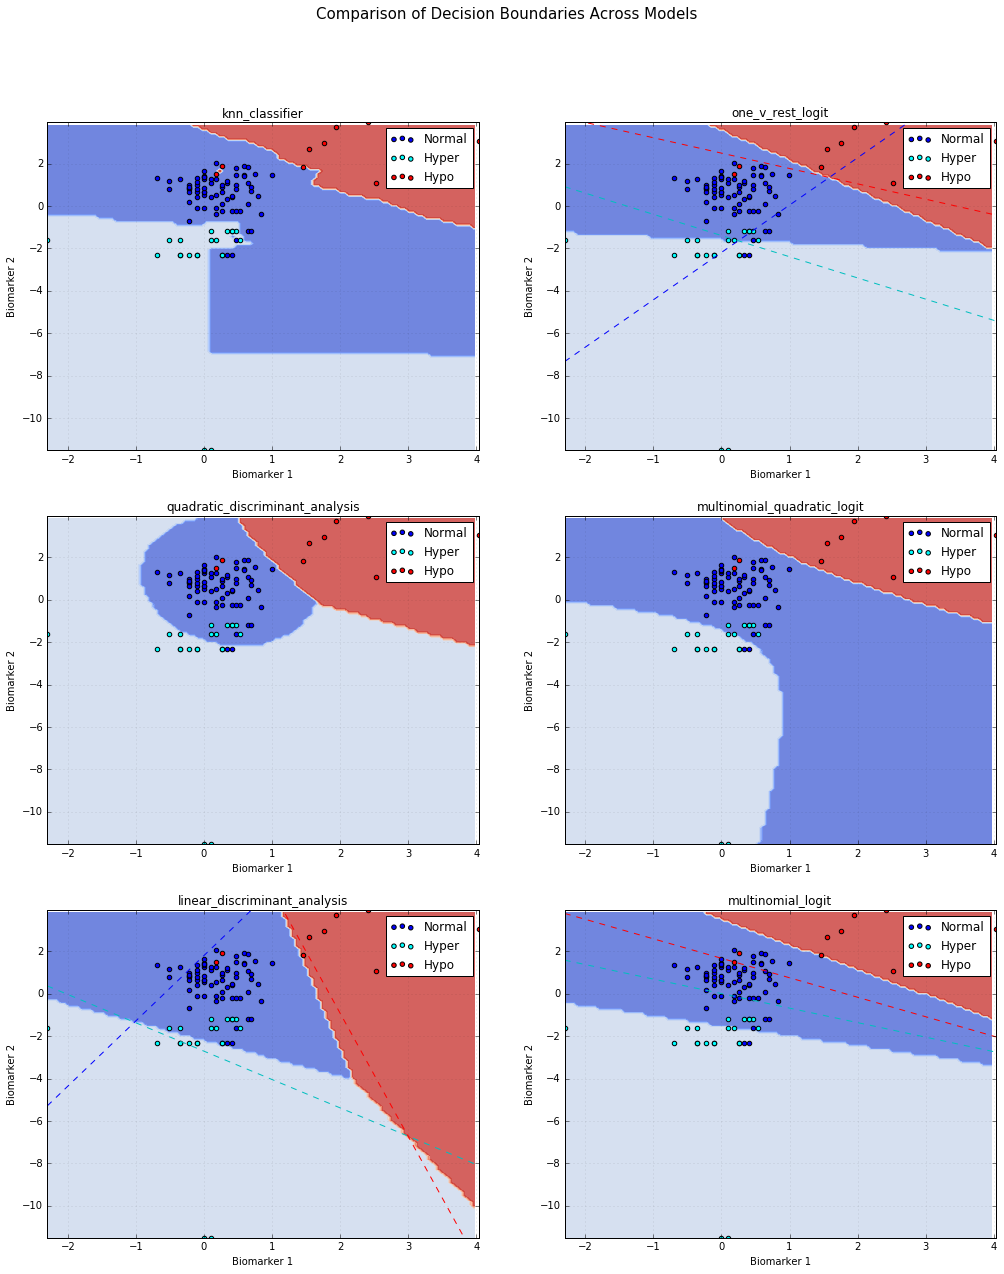

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(17,20))

# plot the rest of the decision boundary plots
for i, key in enumerate(model_characteristics):
    try:
        if key == 'logit_quadratic':
            plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                   datasets['original']['y_train'], \
                                   model_characteristics[key]['model'], \
                                   model_characteristics[key]['model_name'], \
                                   axes[i - (i//2)*3, i//3], \
                                   poly_degree=2)
        elif key in ['logit_multinomial', 'logit_ovr', 'lda']:
            plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                   datasets['original']['y_train'], \
                                   model_characteristics[key]['model'], \
                                   model_characteristics[key]['model_name'], \
                                   axes[i - (i//2)*3, i//3], \
                                   poly_degree=None, \
                                   logit=True)
        else:
            plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                   datasets['original']['y_train'], \
                                   model_characteristics[key]['model'], \
                                   model_characteristics[key]['model_name'], \
                                   axes[i - (i//2)*3, i//3], \
                                   poly_degree=None)
    except IndexError:
        pass

plt.suptitle('Comparison of Decision Boundaries Across Models', size=15)

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

### Differences Between Decision Boundaries: OvR vs. Multinomial Logit

There is a slight difference in the decision boundaries between the OvR and the Multinomial logit model.  While the boundaries for the two models have similar shapes, it is observed that the OvR model has a decision boundary that has a slightly less steep negative slope than the multinomial model for the separation between Hyper and Normal patients.  The steepness of the boundary between Normal and Hypo is about equal.  This difference is highlighted when looking at the hyperplanes (dashed lines) of teh two models.  It is clear when looking at the hyperplanes that the OvR model does a better job of independently classifying the points, whereas the multinomial model is more focused on the bigger picture.  

### Differences Between Decision Boundaries: Linear Logit vs. LDA

The logistic regression models' decision boundaries compared with the LDA model's boundaries vary only slightly.  It is observed that the boundaries produced when going from multinomial to one-vs-rest to LDA push the intersection between the Normal group and the Hypo group further left on the Biomarker 1 axis.  

### Differences Between Decision Boundaries: Quadratic Logit vs. QDA

The decision boundaries for LDA and QDA are dramatically different.  Whereas the LDA model has linear decision boundaries, the QDA model has curved boundaries.  This is to be expected due to the quadratic nature of the objective function employed by QDA, which stems from the fact that LDA assumes that the covariances between the groups is equal while QDA does not.  The assumption of equal covariances, from simply eyeballing the multinomial distribution on the scatterplot, does not appear true.

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

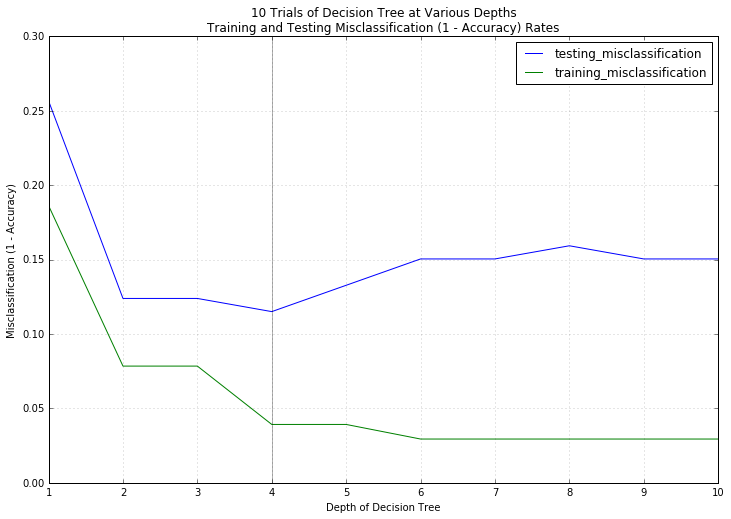

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
np.random.seed(7)

depths, train_acc, test_acc = np.arange(1, 11, 1), [], []
for d in depths:
    # instantiate and fit the model at depth d
    _dtree = DecisionTreeClassifier(criterion='gini', max_depth=d)
    _dtree.fit(datasets['original']['x_train'], datasets['original']['y_train'])
    
    # get predictions and scores for train
    _yhat_train = _dtree.predict(datasets['original']['x_train'])
    _train_acc = zero_one_loss(datasets['original']['y_train'], _yhat_train)
    train_acc.append(_train_acc)
    
    # get predictions and scores for test
    _yhat_test = _dtree.predict(datasets['original']['x_test'])
    _test_acc = zero_one_loss(datasets['original']['y_test'], _yhat_test)
    test_acc.append(_test_acc)
    
tree_df = pd.DataFrame({'training_misclassification':train_acc, 'testing_misclassification':test_acc}, index=depths)
tree_df.plot(figsize=(12, 8))
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Misclassification (1 - Accuracy)')
plt.title('10 Trials of Decision Tree at Various Depths\nTraining and Testing Misclassification (1 - Accuracy) Rates')
plt.grid(alpha=0.4)
min_misclass = tree_df.testing_misclassification == tree_df.testing_misclassification.min()
plt.axvline(tree_df[min_misclass].index.values, c='black', alpha=.3)

In [13]:
from sklearn.model_selection import KFold
np.random.seed(7)

# get Decision Tree best and make predictions on test set
best_parameters = []
param_grid = {'max_depth': depths}
dtree = DecisionTreeClassifier()

# perform KFold with 5 splits
kfold = KFold(n_splits=5, shuffle=True)
k = 1

for train_ix, test_ix in kfold.split(datasets['original']['x_train']):
    _xtrain, _xtest = datasets['original']['x_train'].iloc[train_ix], datasets['original']['x_test'].iloc[test_ix]
    _ytrain, _ytest = datasets['original']['y_train'].iloc[train_ix], datasets['original']['y_test'].iloc[test_ix]

    _bestmodel = cv_optimize_evaluate(dtree, param_grid, _xtrain, _ytrain, \
                                      _xtest, _ytest, 'decision_tree_classifier_fold' + str(k))
    _bestparams = _bestmodel['model'].best_params_
    best_parameters.append(_bestparams)
    k += 1
    
mean_max_depth = round(pd.DataFrame(best_parameters).mean(), 0)
print('Mean max depth = %.3f' %mean_max_depth)

Training Score: 0.9136

    Confusion Matrix for Model: decision_tree_classifier_fold1
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           13            1            0     14
Test_2            1            1            0      2
Test_3            0            0            5      5
Total            14            2            5     21

    Metrics for Model: decision_tree_classifier_fold1
    ------------------------------------------------------
    Accuracy Rate = 0.90476
    Misclassification Rate = 0.09524
    
Training Score: 0.8765

    Confusion Matrix for Model: decision_tree_classifier_fold2
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           12            2            1     15
Test_2            1            1            0      2
Test_3            0            0            4      4
Total            13            3            5  


    Confusion Matrix for Model: decision_tree_classifier
    ------------------------------------------------------
        Condition_1  Condition_2  Condition_3  Total
Test_1           73            6            4     83
Test_2            3           11            0     14
Test_3            1            0           15     16
Total            77           17           19    113

    Metrics for Model: decision_tree_classifier
    ------------------------------------------------------
    Accuracy Rate = 0.87611
    Misclassification Rate = 0.12389
    


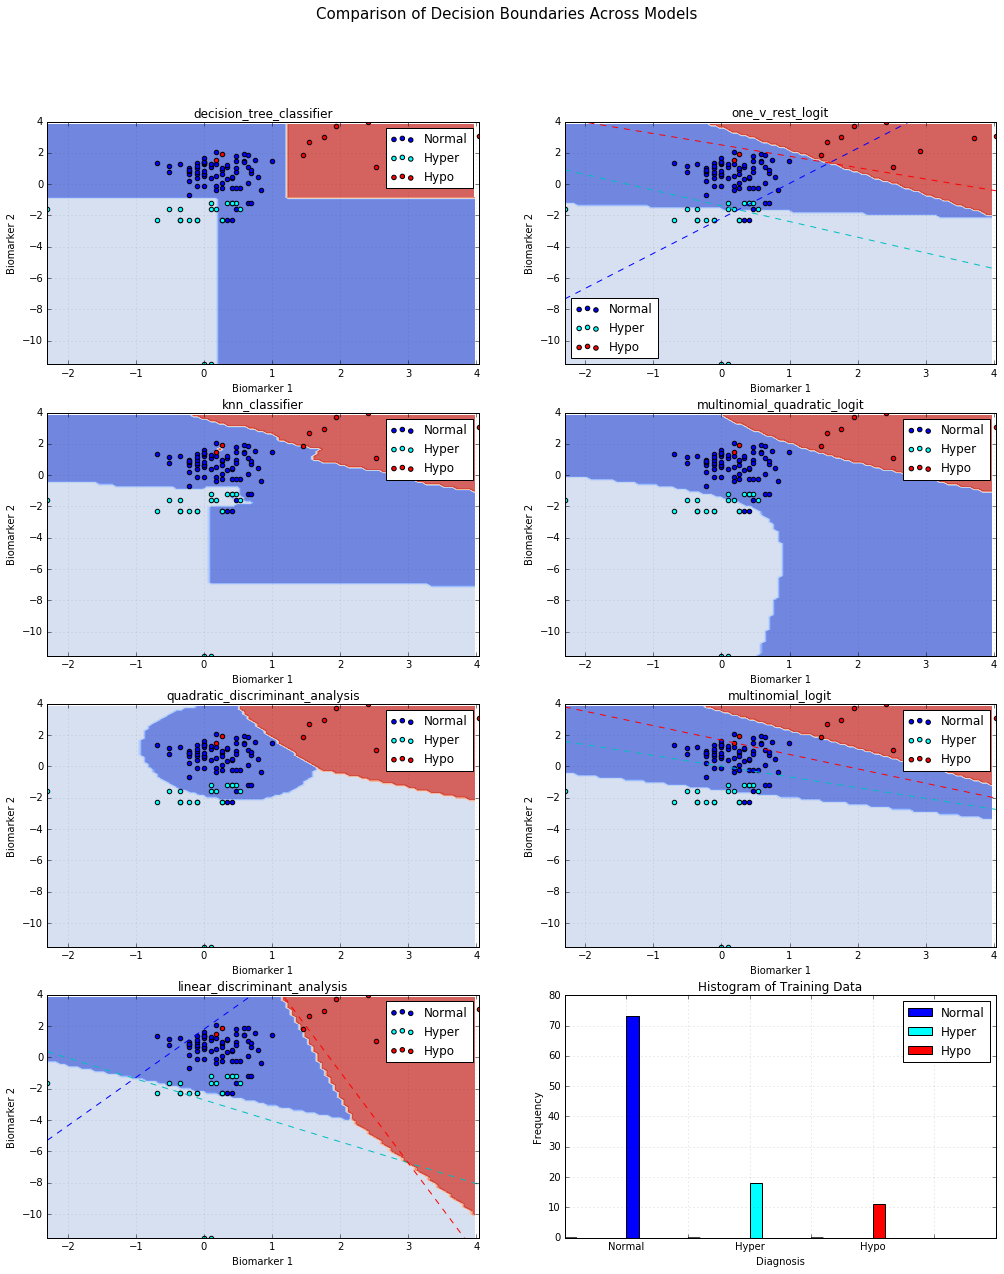

In [14]:
# get Decision Tree using depth of 3 and make predictions on test set
dtree = DecisionTreeClassifier(max_depth=3)

model_characteristics['dtree'] = cv_optimize_evaluate(model=dtree, \
                                           param_grid=None, \
                                           x_train=datasets['original']['x_train'], \
                                           y_train=datasets['original']['y_train'], \
                                           x_test=datasets['original']['x_test'], \
                                           y_test=datasets['original']['y_test'], \
                                           model_name='decision_tree_classifier')

fig, axes = plt.subplots(4, 2, figsize=(17,20))

axes[3, 1].hist(data_train.loc[data_train.Diagnosis == 1, 'Diagnosis'], color='blue', label='Normal')
axes[3, 1].hist(data_train.loc[data_train.Diagnosis == 2, 'Diagnosis'], color='cyan', label='Hyper')
axes[3, 1].hist(data_train.loc[data_train.Diagnosis == 3, 'Diagnosis'], color='red', label='Hypo')
axes[3, 1].legend(loc='best')
axes[3, 1].set_title('Histogram of Training Data')
axes[3, 1].set_xlabel('Diagnosis')
axes[3, 1].set_ylabel('Frequency')
axes[3, 1].set_xticklabels(['', 'Normal', '', 'Hyper', '', 'Hypo'])
axes[3, 1].grid(alpha=.3)

for i, key in enumerate(model_characteristics):
    try:
        if key == 'logit_quadratic':
            plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                   datasets['original']['y_train'], \
                                   model_characteristics[key]['model'], \
                                   model_characteristics[key]['model_name'], \
                                   axes[i - (i//4)*4, i//4], \
                                   poly_degree=2)
        elif key in ['logit_multinomial', 'logit_ovr', 'lda']:
                plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                       datasets['original']['y_train'], \
                                       model_characteristics[key]['model'], \
                                       model_characteristics[key]['model_name'], \
                                       axes[i - (i//4)*4, i//4], \
                                       poly_degree=None, \
                                       logit=True)
        else:
            plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                   datasets['original']['y_train'], \
                                   model_characteristics[key]['model'], \
                                   model_characteristics[key]['model_name'], \
                                   axes[i - (i//4)*4, i//4], \
                                   poly_degree=None)
    except IndexError:
        pass
    
plt.suptitle('Comparison of Decision Boundaries Across Models', size=15)
#plt.savefig(path + 'boundaryplot.png')

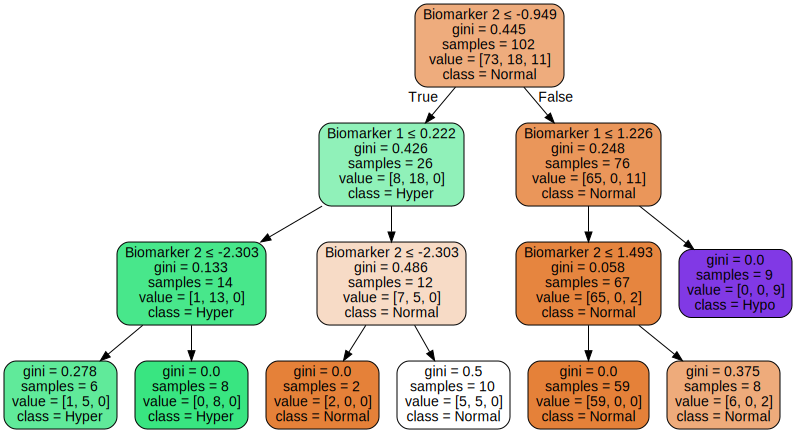

In [15]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(model_characteristics['dtree']['model'], 
                           out_file=None,#'/Volumes/EMTEC/Harvard/HW7/dtree.dot',
                           feature_names=datasets['original']['x_train'].columns,
                           class_names=['Normal', 'Hyper', 'Hypo'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph

### Accuracy On Training

As is shown on the Misclassification plot above, the misclassification rate decreases as the maximum tree depth gets larger.  At higher values for maximum tree depth we see that the training accuracy approaches perfection, a sign that the model is overfitting to the training data.  Further corroborating this suspicion is the fact that the test accuracy begins to deteriorate after a certain level as the training accuracy continues to improve.  

### Performance of Optimal Tree Depth vs. Previous Models

The decision tree model performs well on the test set, achieving the second highest classification accuracy rate of 87.6% (tied with the logistic one-vs-rest model and the logistic multinomial model).   

### Comparison of Decision Boundaries Between Models

The decision boundaries for the decision tree model at a depth of 3 are easy to interpret.  We see that there are three box-like regions that correspond to the thresholds predicted by the model and visualized on the tree above.  This sequential splitting is markedly different from the other methods in that we are not calculating decision boundaries based on some function, but rather following a sequential comparison of values versus static numeric thresholds that are set during the model training of the model.  

### How the Tree Model Diagnoses Hypothyroidism

If we first find that given patient's value for Biomarker 2 is greater than -0.9485, we then check whether their Biomarker 1 level is greater than 1.2259.  If so, the patient likely has Hypothyroidism; if not, they're likely Normal.

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

,memory_usage,accuracy,ease_of_interpretability,boundary_complexity
dtree,2117,0.876106,high,low
knn,53398,0.867257,low,high
lda,21557,0.831858,low,low
logit_multinomial,24245,0.876106,medium,low
logit_ovr,24365,0.876106,medium,low
logit_quadratic,24245,0.884956,low,medium
qda,59778,0.867257,low,medium


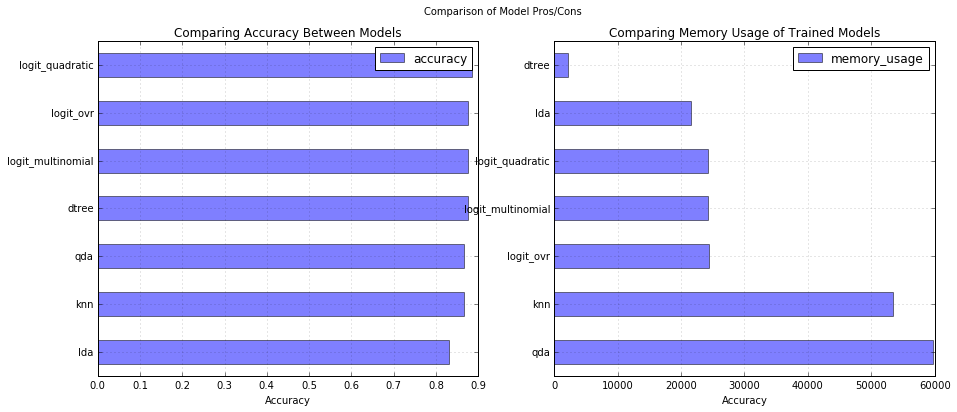

In [16]:
# gather performance metrics
import sys

def get_size(obj, seen=None):
    '''
    Recursively finds size of objects
    Modified from: https://goshippo.com/blog/measure-real-size-any-python-object/
    
    Inputs:
    ------------------------------------------------------
    obj: object to find memory storage
    
    Outputs:
    ------------------------------------------------------
    size: size taken up by object
    '''
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    
    return size

# gather performane information
performance = {}
for key in model_characteristics:
    performance[key] = {'accuracy':model_characteristics[key]['metrics']['accuracy'], \
                       'memory_usage':get_size(model_characteristics[key]['model'])}

performance['dtree'].update({'boundary_complexity':'low', 'ease_of_interpretability':'high'})
performance['knn'].update({'boundary_complexity':'high', 'ease_of_interpretability':'low'})
performance['lda'].update({'boundary_complexity':'low', 'ease_of_interpretability':'low'})
performance['qda'].update({'boundary_complexity':'medium', 'ease_of_interpretability':'low'})
performance['logit_quadratic'].update({'boundary_complexity':'medium', 'ease_of_interpretability':'low'})
performance['logit_ovr'].update({'boundary_complexity':'low', 'ease_of_interpretability':'medium'})
performance['logit_multinomial'].update({'boundary_complexity':'low', 'ease_of_interpretability':'medium'})

performance_df = pd.DataFrame.from_dict(performance, orient='index')

# generate simple plots to show memory and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
performance_df.sort_values(by='accuracy')[['accuracy']].plot(kind='barh', ax=ax[0], alpha=.5)
ax[0].set_title('Comparing Accuracy Between Models')
ax[0].set_xlabel('Accuracy')
ax[0].grid(alpha=0.4)

performance_df.sort_values(by='memory_usage', ascending=False)[['memory_usage']].plot(kind='barh', ax=ax[1], alpha=.5)
ax[1].set_title('Comparing Memory Usage of Trained Models')
ax[1].set_xlabel('Accuracy')
ax[1].grid(alpha=0.4)

plt.suptitle('Comparison of Model Pros/Cons')

performance_df

### Assessment of Model Practicality

All models tested thus far are evaluated on four criteria: classification performance, complexity of the decision boundary, memory storage, and ease of interpretability.  Both classification performance and memory storage are measured objectively while the other two are more subjective.  Models are discussed in order of ascending classification accuracy below.

While classification performance is similar between models with a mean value of 86.9%, the Linear Discriminant Analysis model appears to lag behind the others with an accuracy of 83.2%.  It is apparent in the plots visualizing the decision boundaries that the LDA model does not have sufficiently complex decision boundaries to capture observations that other models were able to capture.  Further, LDA's ease of interpretability is relatively low.  These reasons are sufficient to not utilize the LDA model.

The KNN model and the QDA model performed identically on the test set with a classification accuracy of 86.7%.  These two models both have high memory requirements for the trained models relative to the others.  Both also have somewhat low interpretability, although KNN may be more interpretable to individuals who have an understanding of Euclidian distance.  The QDA model has medium comlexity w.r.t. the decision boundary (as judged by its qudratic shapes) while the KNN model, using a K of 3, has complex decision boundaries.  In addition to the afforementioned reasons, these two models are also tied for 3rd in accuracy, and thus will not be considered for production.  

The multinomial logistic regression model, one-vs-rest logistic regresion model, and the decision tree model all had identical performance (with an accuracy of 87.6%) and tie for 2nd place w.r.t. accuracy on the test set.  All three of these have relatively low decision boundary complexity, with the decision tree model having the lowest given that the boundaries are orthogonal to the axes (as opposed to linear functions).  The decision tree model appears to have the highest interpretability (since it can be visualized as a tree) and the lowest memory requirements out of the three.  

The highest ranking model w.r.t. classification accuracy was the quadratic logistic regression model, achieving 88.5% accuracy.  This model has nearly identical memory requirements to the logistic models with linear main effects, yet has lower interpretability and higher boundary complexity than these other logistic models.  

If I were a clinician (assuming I'd then have no knowledge of these models) I would feel most comfortable using the decision tree model, despite it being tied for second place w.r.t. accuracy.  The tree visualization helps to prioritize levels of discrimination and to think through the meaning of the biomarkers in a sequential fashion.  It also is less than one percentage point worse than the best model, yet is vastly easier to comprehend and explain.  

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [17]:
# avg cost from OvR logistic regression on test set
def calculate_cost_at_threshold(probabilities, y_test, classes, cost_misclassification, cost_abstain, threshold):
    '''
    Takes predicted probabilities and organizes into pd.DataFrame; calculates 
    cost of abstaining & misdiagnosing at given thresholds for abstaining
    from making a prediction as a fn of the maximum probability
    
    Inputs:
    ------------------------------------------------------
    probabilities: probabilities of labels of test (from model)
    y_test: true labels test set
    classes: list of class names
    cost_misclassification: cost per event of misclassification
    cost_abstain: cost per event of choosing not to predict
    threshold: cutoff to say below this we won't make prediciton for phat
    
    Outputs:
    ------------------------------------------------------
    pr_df, cost_at_threshold, cost_wo_abstaining
    probability info, avg cost at threshold, avg cost status quo (not abstaining)
    '''
    pr_df = pd.DataFrame(probabilities, columns=classes)
    pr_df['y_actual'] = y_test.values
    pr_df['y_hat'] = pr_df[classes].idxmax(axis=1)
    pr_df['prob_yhat'] = pr_df[classes].max(axis=1)
    pr_df['correct'] = pr_df['y_hat'] == pr_df['y_actual']
    
    # row by row IDs max probability and its index
    maxp_less_others, maxp_less_nextp = [], []
    for ix, row in pr_df[classes].iterrows():
        maxcol = row.idxmax()
        othercols = [col for col in classes if col != row.idxmax()]
        maxp_less_others.append(row[maxcol] - row[othercols].sum())
        maxp_less_nextp.append(row[maxcol] - row[row[othercols].idxmax()])
    
    # id maxp compared to others
    pr_df['maxp_less_others'] = maxp_less_others 
    pr_df['maxp_less_nextp'] = maxp_less_nextp
    pr_df['abstain'] = False
    
    # get cost w/o abstaining
    pr_df['cost'] = 0
    pr_df.loc[pr_df.abstain == True, 'cost'] = cost_abstain
    pr_df.loc[pr_df.correct == False, 'cost'] = cost_misclassification
    cost_wo_abstaining = pr_df['cost'].mean()
    
    # get cost w/ threshold
    pr_df['cost'] = 0
    pr_df.loc[pr_df['prob_yhat'] < threshold, 'abstain'] = True
    pr_df.loc[pr_df.abstain == True, 'cost'] = cost_abstain
    pr_df.loc[pr_df.abstain == True, 'correct'] = np.nan
    pr_df.loc[pr_df.correct == False, 'cost'] = cost_misclassification
              
    # get avg cost
    cost_at_threshold = pr_df['cost'].mean()
    
    return pr_df, cost_at_threshold, cost_wo_abstaining
              
def find_optimal_threshold(thresholds, probabilities, y_test, classes, cost_misclassification, cost_abstain):
    '''
    Iteratively finds optimal cutoff for abstaining
    
    Inputs:
    ------------------------------------------------------
    thresholds: value of threshold 0 through 1
    probabilities: probabilities matrix of yhat of model
    y_test: true labels of test set
    classes: class names
    cost_misclassification: cost of misclass
    cost_abstain: cost to abstain and send to specialist
    
    Outputs:
    ------------------------------------------------------
    pr_df: expanded dataframe of probability info
    cost_at_threshold: optimal avg cost at given threshold
    cost_wo_abstaining: avg cost when not abstaining at all
    '''
    _costs = {}
    for threshold in thresholds:
        pr_df, cost_at_threshold, cost_wo_abstaining = calculate_cost_at_threshold(probabilities, y_test, classes, \
                                                                                   cost_misclassification, cost_abstain, threshold)
        _costs[threshold] = {'cost_at_threshold':cost_at_threshold, 'cost_wo_abstaining':cost_wo_abstaining}
    
    # ID optimal threshold that minimizes cost & get prob df and costs
    _cost_df = pd.DataFrame(_costs).T
    optimal_threshold = _cost_df['cost_at_threshold'].idxmin(axis=0)
    pr_df, cost_at_threshold, cost_wo_abstaining = calculate_cost_at_threshold(probabilities, \
                                                                               y_test, \
                                                                               classes, \
                                                                               cost_misclassification, \
                                                                               cost_abstain, \
                                                                               optimal_threshold)
              
    return pr_df, cost_at_threshold, cost_wo_abstaining, optimal_threshold

              
# first calc cost as is for each prediction, then optimize iteratively
classes = [1, 2, 3]
thresholds = np.arange(0, 1, .01)
cost_misclassification = 5000
cost_abstain = 1000

# gather all probability info and cost info into a dataframe; 
# derive optimal cost, threshold and status quo
pr_df, cost_at_threshold, cost_wo_abstaining, optimal_threshold = find_optimal_threshold(thresholds, \
                                                                                         model_characteristics['logit_ovr']['probabilities'], \
                                                                                         y_test, \
                                                                                         classes, \
                                                                                         cost_misclassification, \
                                                                                         cost_abstain)
pr_df.head()

,1,2,3,y_actual,y_hat,prob_yhat,correct,maxp_less_others,maxp_less_nextp,abstain,cost
0,0.980621,0.016663,0.002717,1.0,1,0.980621,1.0,0.961241,0.963958,False,0
1,0.975605,0.023207,0.001188,1.0,1,0.975605,1.0,0.951210,0.952398,False,0
2,0.983845,0.011779,0.004375,1.0,1,0.983845,1.0,0.967691,0.972066,False,0
3,0.983973,0.008592,0.007436,1.0,1,0.983973,1.0,0.967945,0.975381,False,0
4,0.983585,0.013118,0.003298,1.0,1,0.983585,1.0,0.967169,0.970467,False,0


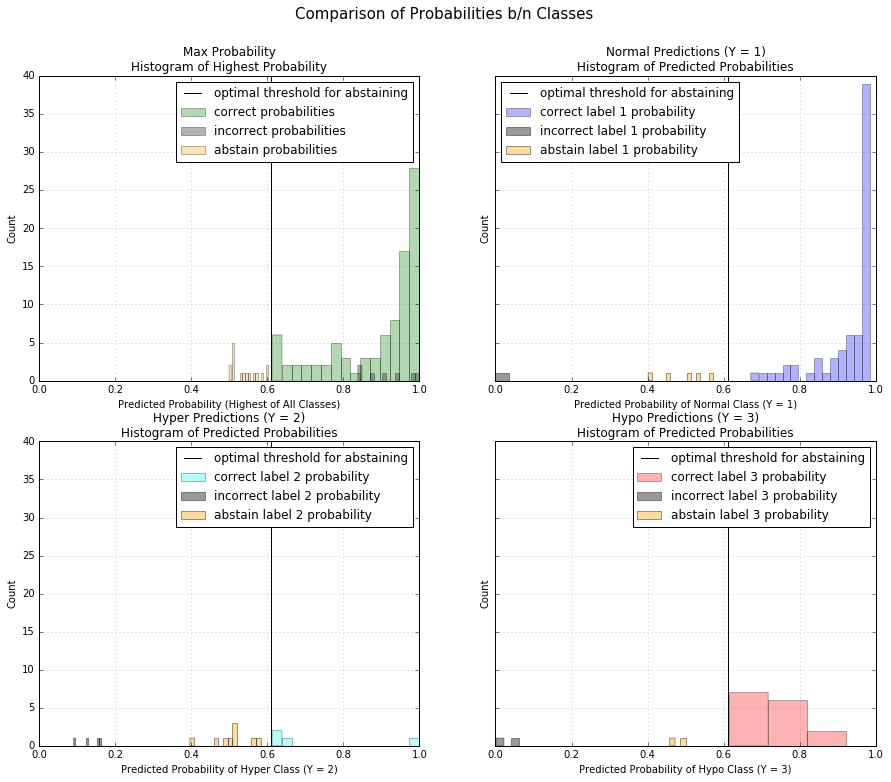

In [18]:
# plot the different groups to get a feel for cutoffs
fig, ax = plt.subplots(2, 2, figsize=(15, 12), sharey=True)

ax[0, 0].hist(pr_df.loc[pr_df['correct']==True, 'prob_yhat'], color='green', \
              bins=15, alpha=0.3, label='correct probabilities')
ax[0, 0].hist(pr_df.loc[pr_df['correct']==False, 'prob_yhat'], color='black',\
              bins=15, alpha=0.3, label='incorrect probabilities')
ax[0, 0].hist(pr_df.loc[pr_df['correct'].isnull(), 'prob_yhat'], color='orange',\
              bins=15, alpha=0.3, label='abstain probabilities')
ax[0, 0].axvline(optimal_threshold, color='black', label='optimal threshold for abstaining')
ax[0, 0].legend(loc='best')
ax[0, 0].set_xlabel('Predicted Probability (Highest of All Classes)')
ax[0, 0].set_ylabel('Count')
ax[0, 0].set_title('Max Probability\nHistogram of Highest Probability')
ax[0, 0].set_xlim([0, 1])
ax[0, 0].grid(alpha=0.4)

ax[0, 1].hist(pr_df.loc[(pr_df['correct']==True) & (pr_df['y_actual']==1), 1], \
              label='correct label 1 probability', alpha=0.3, color='blue', bins=15)#cyan red
ax[0, 1].hist(pr_df.loc[(pr_df['correct']==False) & (pr_df['y_actual']==1), 1], \
              label='incorrect label 1 probability', alpha=0.4, color='black', bins=15)
ax[0, 1].hist(pr_df.loc[(pr_df['correct'].isnull()) & (pr_df['y_actual']==1), 1], \
              label='abstain label 1 probability', alpha=0.4, color='orange', bins=15)
ax[0, 1].axvline(optimal_threshold, color='black', label='optimal threshold for abstaining')
ax[0, 1].legend(loc='best')
ax[0, 1].set_xlabel('Predicted Probability of Normal Class (Y = 1)')
ax[0, 1].set_ylabel('Count')
ax[0, 1].set_title('Normal Predictions (Y = 1)\nHistogram of Predicted Probabilities')
ax[0, 1].set_xlim([0, 1])
ax[0, 1].grid(alpha=0.4)


ax[1, 0].hist(pr_df.loc[(pr_df['correct']==True) & (pr_df['y_actual']==2), 2], \
              label='correct label 2 probability', alpha=0.3, color='cyan', bins=15)#cyan red
ax[1, 0].hist(pr_df.loc[(pr_df['correct']==False) & (pr_df['y_actual']==2), 2], \
              label='incorrect label 2 probability', alpha=0.4, color='black', bins=15)
ax[1, 0].hist(pr_df.loc[(pr_df['correct'].isnull()) & (pr_df['y_actual']==2), 2], \
              label='abstain label 2 probability', alpha=0.4, color='orange', bins=15)
ax[1, 0].axvline(optimal_threshold, color='black', label='optimal threshold for abstaining')
ax[1, 0].legend(loc='best')
ax[1, 0].set_xlabel('Predicted Probability of Hyper Class (Y = 2)')
ax[1, 0].set_ylabel('Count')
ax[1, 0].set_title('Hyper Predictions (Y = 2)\nHistogram of Predicted Probabilities')
ax[1, 0].grid(alpha=0.4)

ax[1, 1].hist(pr_df.loc[(pr_df['correct']==True) & (pr_df['y_actual']==3), 3], \
              label='correct label 3 probability', alpha=0.3, color='red', bins=3)
ax[1, 1].hist(pr_df.loc[(pr_df['correct']==False) & (pr_df['y_actual']==3), 3], \
              label='incorrect label 3 probability', alpha=0.4, color='black', bins=3)
ax[1, 1].hist(pr_df.loc[(pr_df['correct'].isnull()) & (pr_df['y_actual']==3), 3], \
              label='abstain label 3 probability', alpha=0.4, color='orange', bins=3)
ax[1, 1].axvline(optimal_threshold, color='black', label='optimal threshold for abstaining')
ax[1, 1].legend(loc='best')
ax[1, 1].set_xlabel('Predicted Probability of Hypo Class (Y = 3)')
ax[1, 1].set_ylabel('Count')
ax[1, 1].set_title('Hypo Predictions (Y = 3)\nHistogram of Predicted Probabilities')
ax[1, 1].grid(alpha=0.4)

plt.suptitle('Comparison of Probabilities b/n Classes', size=15)

In [19]:
print('''
OvR Logistic Regression:
---------------------------------------------------
Optimal threshold for abstaining = %.4f
Average cost at optimal threshold = %.4f
Average cost w/o abstaining = %.4f
''' %(optimal_threshold, cost_at_threshold, cost_wo_abstaining))


OvR Logistic Regression:
---------------------------------------------------
Optimal threshold for abstaining = 0.6100
Average cost at optimal threshold = 451.3274
Average cost w/o abstaining = 619.4690



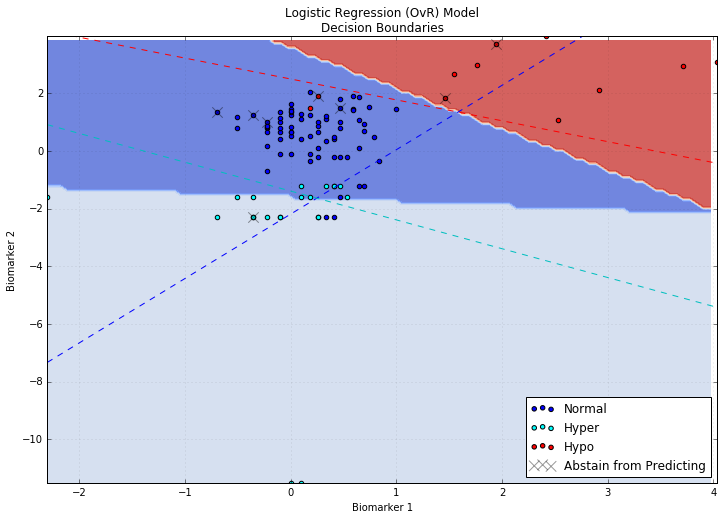

In [20]:
probs = model_characteristics['logit_ovr']['model'].predict_proba(x_train)
pr_df, cost_at_threshold, cost_wo_abstaining, optimal_threshold = find_optimal_threshold(thresholds, \
                                                                                         probs, \
                                                                                         y_train, \
                                                                                         classes, \
                                                                                         cost_misclassification, \
                                                                                         cost_abstain)

fig, ax = plt.subplots(figsize=(12, 8))
plot_decision_boundary(datasets['original']['x_train'].as_matrix(), \
                                   datasets['original']['y_train'], \
                                   model_characteristics['logit_ovr']['model'], \
                                   'Logistic Regression (OvR) Model\nDecision Boundaries', \
                                   ax, \
                                   poly_degree=None, \
                                   logit=True)

ax.scatter(datasets['original']['x_train'].loc[pr_df.index[pr_df.abstain==True], 'Biomarker 1'], \
              datasets['original']['x_train'].loc[pr_df.index[pr_df.abstain==True], 'Biomarker 2'], \
              s=110, c='black', marker='x', alpha=.4, label='Abstain from Predicting')
ax.legend(loc='lower right')

#plt.savefig('D:/Harvard/HW7/logit_ovr_decision_boundaries_w_abstain.png')

### Strategy for Abstaining from Prediction 

The average cost per patient when using the logistic regression one-vs-rest model is just over 619 dollars when there is no abstaining criteria.  

In iterative approach was employed to minimize this cost that takes into account the maximum probability (e.g. the prediction class's probability), sets a threshold under which the model will abstain, and then calculates the cost.  

The cost was calculated on every threshold value in a generated vector that ranges from 0 to 1 (incremented by 0.01), under which any "winning" probability is withheld from making a prediction.  For example, if the threshold is 0.5, and the highest probability for a given observation is 0.4, then the model will abstain from prediction.  By saving each value in this iterative process a minimum cost was found at a threshold of 0.61, corresponding with a cost of just over 451 dollars per patient.  An optimal value for OvR logistic regression was found at 0.61 (at the costs provided), yielding an average cost per patient of 451.33 dollars, roughly one hundred and seventy dollars less than the cost when no abstention is employed.  Further, this approach can be extended to accomodate changing costs of misclassification and abstaining.